# Advanced Lane Finding Project

---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
from moviepy.editor import VideoFileClip
from image_processing import *
from pipeline import *

%matplotlib inline

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the file called `camera_cal.py`.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection. For collecting the points, I use the provided calibration images. However some of the images have not captured fully all of the corners and could not be processed. Therefore images `calibration1.jpg`, `calibration4.jpg` and `calibration5.jpg` were not used in the calibration process.

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 


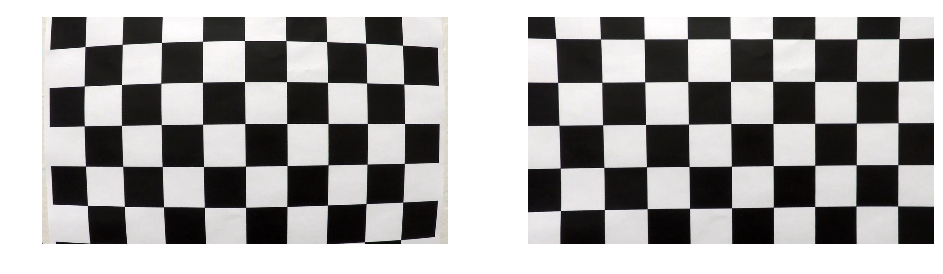

In [2]:
img = imread('./camera_cal/calibration1.jpg')
undist = undistort(img)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(img)
plt.subplot(122)
plt.axis('off')
plt.imshow(undist)
plt.show()

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
I have defined a function in `pipeline.py`:

```python
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
```
To demonstrate this step, I apply the distortion correction to one of the test images like this one:

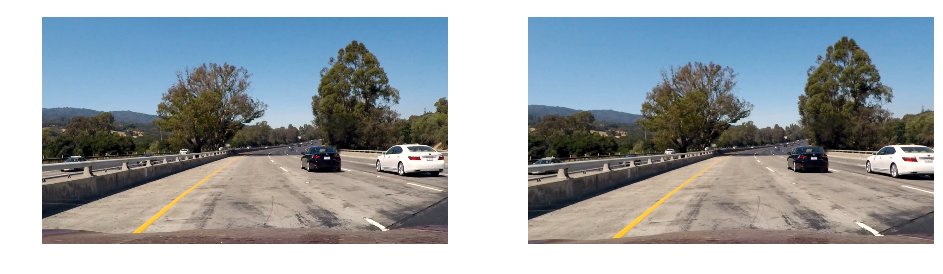

In [3]:
img = imread('./test_images/test1.jpg')
undist = undistort(img)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(img)
plt.subplot(122)
plt.axis('off')
plt.imshow(undist)
plt.show()

#### 2. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warp()`, which appears in lines 34 through 37 in the file `pipeline.py`. The `warp()` function takes as inputs an image (`img`) and it has access to the perspective transformed matrix `M` which is calculated in the beginning of the file `pipeline.py` from the source (`src`) and destination (`dst`) points. I chose to hardcode the source and destination points in the following manner:

```python
src = np.float32([[220,720],[1110,720],[735,480],[554,480]])
dst = np.float32([[320,720],[960,720],[960,0],[320,0]])
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 220, 720      | 320, 720     | 
| 1110, 720     | 960, 720     |
| 735, 480      | 960, 0       |
| 554, 480      | 320, 0       |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

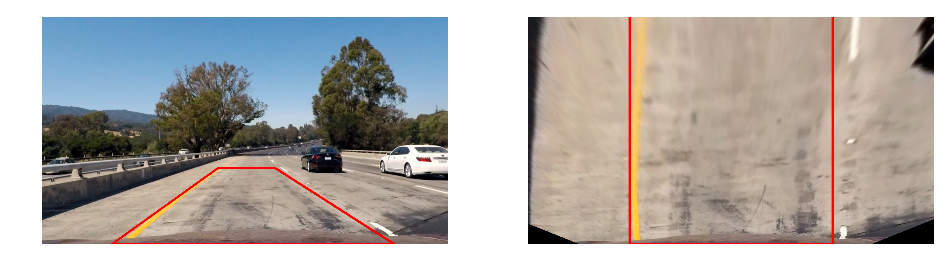

In [4]:
warped = warp(undist)
undist1 = draw_perspective(undist)
warped1 = draw_perspective(warped, True)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(undist1)
plt.subplot(122)
plt.axis('off')
plt.imshow(warped1)
plt.show()

#### 3. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I have implemented both gradient and color thresholds, but I have only used the color threshold since the gradient threshold appears to be too noisy in some of the road textures. The final result is a binary image (color thresholding is done in steps at lines #58 through #72 in `image_processing.py`). Here's an example of my output for this edge thresholding:

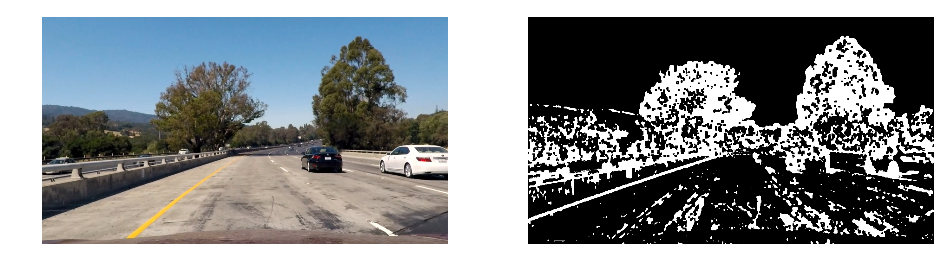

In [5]:
edges = edge_thresh(undist)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(undist)
plt.subplot(122)
plt.axis('off')
plt.imshow(edges, cmap='gray')
plt.show()

And here the result from my color threshold:

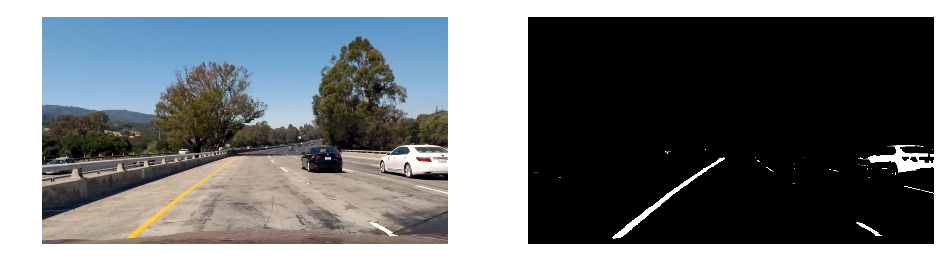

In [6]:
hls = color_thresh(undist)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(undist)
plt.subplot(122)
plt.axis('off')
plt.imshow(hls, cmap='gray')
plt.show()

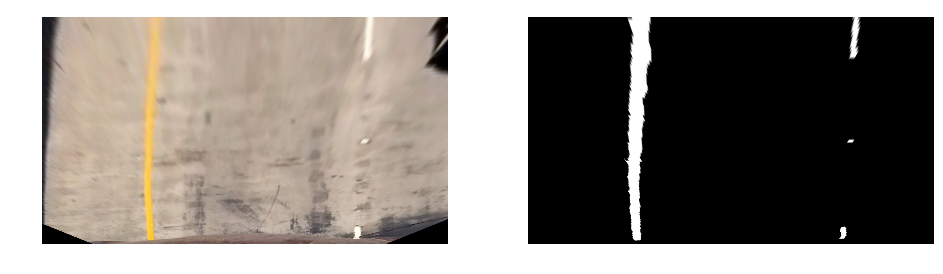

In [7]:
bin_warped = warp(hls)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(warped)
plt.subplot(122)
plt.axis('off')
plt.imshow(bin_warped, cmap='gray')
plt.show()

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

For identifying the lane-line pixels, a function called `find_window_centroids()` was implemented in `lane.py`, lines #29 - #66. This function divides the image into 9 horizontal slices and starts scanning each of them by applying convolution on the histogram of these slices. The peak result of the convolution on the left is considered to be the left line and the peak one is considered to be the right line. Each window is centered by finding the maximum histogram value in the window. The same is done for the other slices, but scanning is limited to a maximum `2*margin` distance from the previously found centroid. If no centroid is found, the one from the previous layer is used. The result of the function is a list of centroids, which is then used to extract the line pixels, which are used for fitting the line polynomials. An example of the usage of the functions could be found here: 

In [8]:
from lane import *

centroids = find_window_centroids(bin_warped, win_width=80, win_height=80, margin=100, minpix=500)
leftx, lefty, rightx, righty = extract_lane_pixels(bin_warped, centroids, margin=100)
# Fit a second order polynomial to each line
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

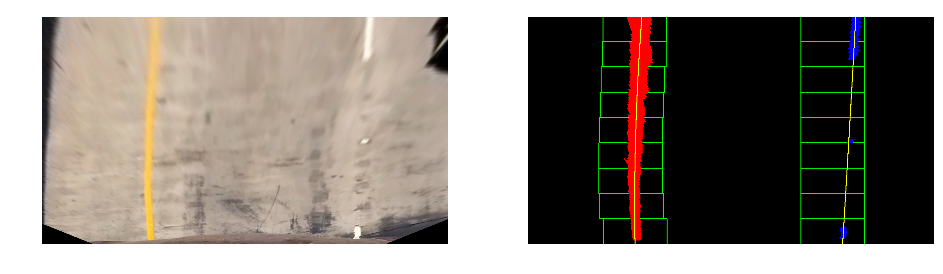

In [9]:
out_img = draw_window_centroids(bin_warped, centroids, leftx, lefty, rightx, righty, margin=100)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(warped)
plt.subplot(122)
plt.axis('off')
plt.imshow(out_img)
plt.show()

Here is an example using the fast lane extraction (function `fast_lane_extract()` defined in `lane.py`), where the inspected region depends on the previously detected polynomials for the two lines:

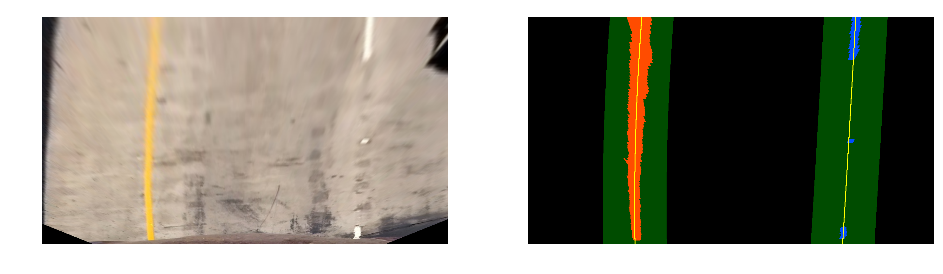

In [10]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "bin_warped")
# It's now much easier to find line pixels!
leftx, lefty, rightx, righty = fast_lane_extract(bin_warped, left_fit, right_fit, margin=100)
fitted = draw_fitted_curve(bin_warped, leftx, lefty, rightx, righty)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(warped)
plt.subplot(122)
plt.axis('off')
plt.imshow(fitted)
plt.show()

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
For calculating the radius of curviture, I have implemented function `curve_rad` which calculates the 2nd order polynomial in world space from the pixel coordinates of the bright pixels in the warped image. The code for the function could be found at lines #78 through #85 in my code in `pipeline.py`. Here is how this function is used:

In [11]:
# Calculate radius of curvature in meters
y_eval = 720
curverad = curve_rad(lefty, leftx, rightx, righty, y_eval)
print(str(curverad) + 'm')

574m


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
Once I have the polynomial for the left and right lines, then I can easily draw a polygons in the warped space for the lines as well as one for the lane. Then the resulting image is transformed with the inverse perspective matrix with function `unwarp` (lines #39 through #42, file `pipeline.py`) and blended with the undistorted original image. I implemented this step in lines #177 through #186 in my code in `lane.py` in the function `draw_lane()`. Here is an example of my result on a test image:

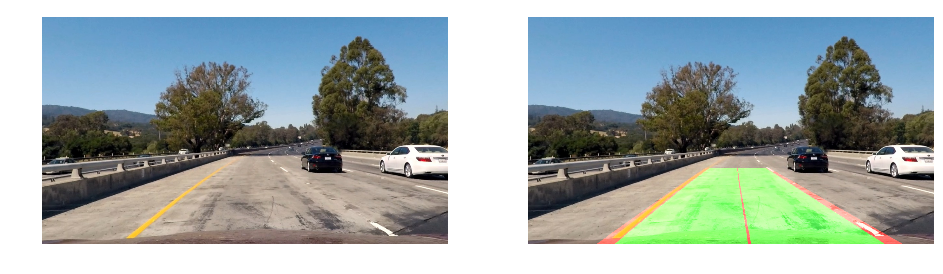

In [12]:
lane = draw_lane(undist, left_fit, right_fit)

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(undist)
plt.subplot(122)
plt.axis('off')
plt.imshow(lane)
plt.show()

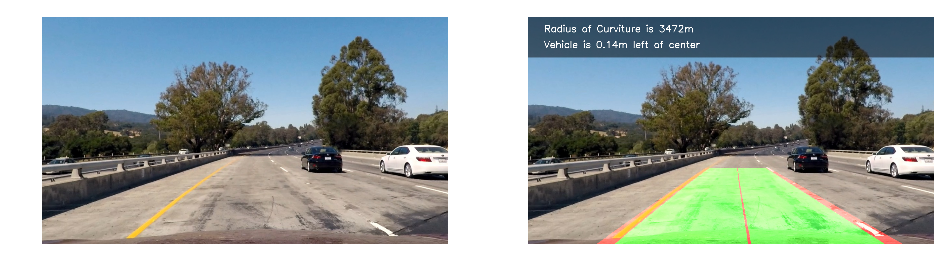

In [13]:
diff = center_diff(left_fit, right_fit, lane.shape[0], lane.shape[1] // 2)
from_center = 'left' if diff < 0 else 'right'
radius = curve_rad(leftx, lefty, rightx, righty, lane.shape[0])
draw_header(lane, 130)
draw_text(lane, "Radius of Curviture is {0}m".format(radius), pos = (50, 50))
draw_text(lane, "Vehicle is {0:.2f}m {1} of center".format(abs(diff), from_center), pos = (50, 100))

plt.figure(figsize=(11.5,8))
plt.subplot(121)
plt.axis('off')
plt.imshow(undist)
plt.subplot(122)
plt.axis('off')
plt.imshow(lane)
plt.show()

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

The processing pipeline was tested on the main project video and it works fine for the first half of it, but the processing crashes in the middle of the video. Here's a [link to my video result](./project_tracked.mp4) and here is a [link to a detailed debug video](./project_detailed.mp4).

---


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The current processing pipeline is very simple and relies too heavy on color thresholding, which fails in certain cituations in the simple video. More work will be done to improve the robustness of the line detection. Information from the gradient threshold is not used currently and that could be a very useful resource for detecting the lines. More over no smoothing between different frames is done and that will be incorporated in the future.

There are a few weaknesses in the current pipeline and one of them is the static perspective transform, which can cause trouble on hilly roads, e.g. like the ones in the harder challenge video. Another problem with the pipeline is that it relies entirely on lane lines and it fails when the marking is old or non-existing.